In [1]:
import pathlib

import cv2
import skimage
import numpy as np
import pandas as pd
import tqdm.notebook as tqdm

import matplotlib
import matplotlib.pyplot as plt

In [2]:
def determine_video_props(video_url):
    cap = cv2.VideoCapture(str(video_url))
    frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    cap.release()

    return frames, width, height, fps

In [3]:
# Video url
video_url = pathlib.Path('~/data/hkv/bank_erosion-copy.mp4').expanduser()

# Basic video properties
frames, width, height, fps = determine_video_props(video_url)

# Row number for timestack
n_timestack = 250

# Which frames to loop over
frames_iter = range(0, frames, 1)

# Pre-allocate arrays
total = np.zeros((height, width, 3), dtype='float32')
max_img = np.zeros_like(total)
min_img = np.ones_like(total)
time_stack = np.empty((width, len(frames_iter), 3), dtype='float32')

In [4]:
def next_img(cap):
    retval, img = cap.read()

    if retval:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = skimage.util.img_as_float32(img)

    return retval, img

In [5]:
# Open video
cap = cv2.VideoCapture(str(video_url))

# loop over frames
n = 0
for i in tqdm.tqdm(range(frames)):
    retval, img = next_img(cap)
    
    if i not in frames_iter:
        continue
    else:
        if (retval):
            total += img
            max_img = np.maximum(max_img, img)
            min_img = np.minimum(min_img, img)
            hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            time_stack[:, n, :] = img[n_timestack, :]
            n += 1
        else:
            raise StopIteration()

# Determine mean
mean_img = total / n

# Close video
cap.release()

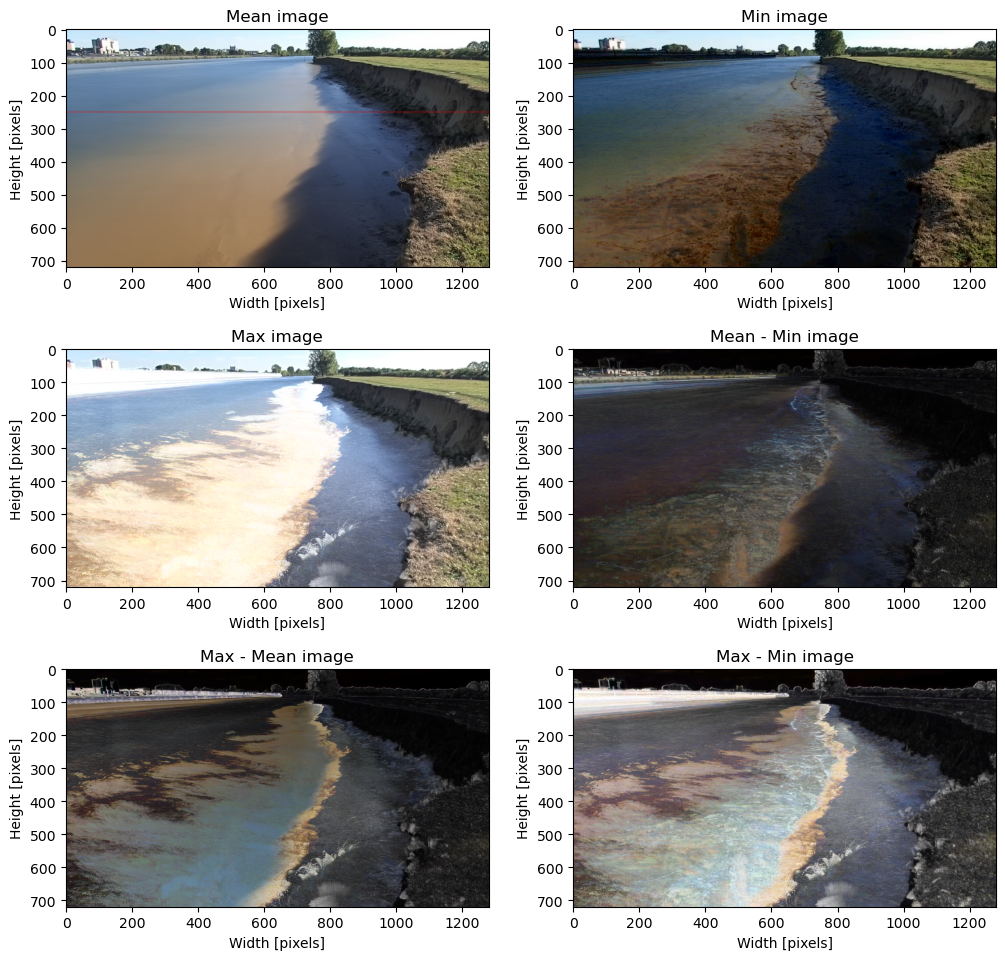

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12), dpi=100)

axes[0, 0].set_title('Mean image')
axes[0, 0].imshow(np.clip(mean_img, 0, 1))
axes[0, 0].axhline(n_timestack, color='red', alpha=0.2)

axes[0, 1].set_title('Min image')
axes[0, 1].imshow(np.clip(min_img, 0, 1))

axes[1, 0].set_title('Max image')
axes[1, 0].imshow(np.clip(max_img, 0, 1))

axes[1, 1].set_title('Mean - Min image')
axes[1, 1].imshow(np.clip(mean_img - min_img, 0, 1))

axes[2, 0].set_title('Max - Mean image')
axes[2, 0].imshow(np.clip(max_img - mean_img, 0, 1))

axes[2, 1].set_title('Max - Min image')
axes[2, 1].imshow(np.clip(max_img - min_img, 0, 1))

for irow in range(axes.shape[0]):
    for icol in range(axes.shape[1]):
        axes[irow, icol].set_xlabel('Width [pixels]')
        axes[irow, icol].set_ylabel('Height [pixels]');

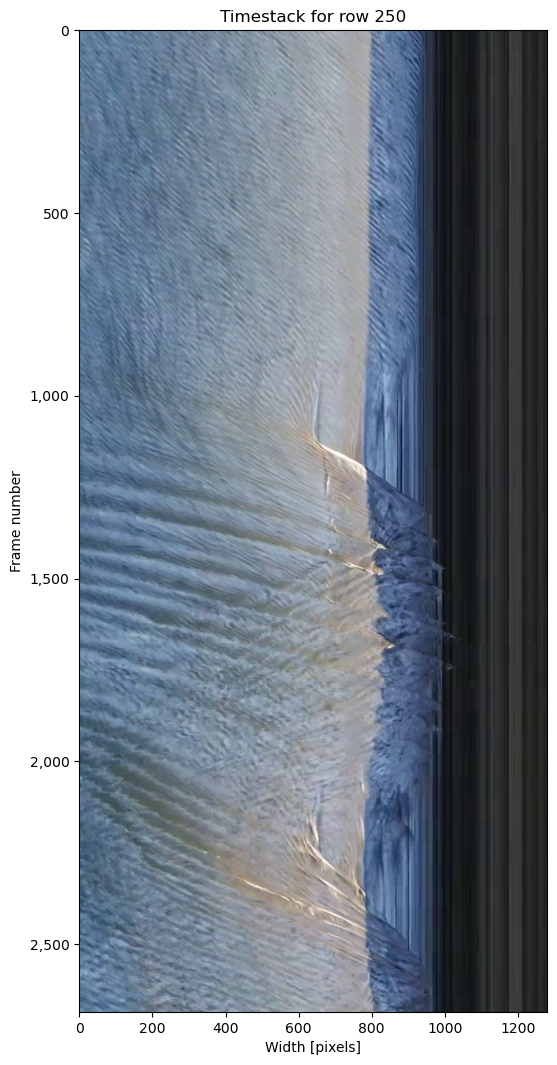

In [7]:
fig, ax = plt.subplots(figsize=(8, 13), dpi=100)

ax.imshow(np.swapaxes(time_stack, 0, 1))
ax.set_title(f'Timestack for row {n_timestack}')
ax.set_ylabel('Frame number')
ax.set_xlabel('Width [pixels]')

ax.set_ylim([len(frames_iter) - 1, 0])
ticks_loc = ax.get_yticks().tolist()[:-1]
ax.set_yticks(ticks_loc)
ax.set_yticklabels(['{:,.0f}'.format(frames_iter[int(x)]) for x in ticks_loc]);

In [8]:
# def framepairs(cap, n=10, s=None):
#     """yield gray framepairs, by sliced by optional s"""
#     if s is None:
#         s = np.s_[:, :]
#     status, img0 = cap.read()
#     if not status == True:
#         raise StopIteration()
#     for i in range(n):
#         status, img1 = cap.read()
#         if not status == True:
#             break
#         gray0 = cv2.cvtColor(img0[s], cv2.COLOR_BGR2GRAY)
#         gray1 = cv2.cvtColor(img1[s], cv2.COLOR_BGR2GRAY)
#         yield gray0, gray1
#         img0, img1 = img1, None

def warp_flow(img, flow):
    """apply a flow field to an image (from opt_flow.py in opencv)"""
    h, w = flow.shape[:2]
    flow = -flow
    flow[:, :, 0] += np.arange(w)
    flow[:, :, 1] += np.arange(h)[:, np.newaxis]
    res = cv2.remap(img, flow, None, cv2.INTER_LINEAR)

    return res

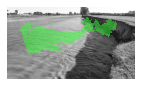

In [10]:
cap = cv2.VideoCapture(str(video_url))

gray0 = np.full((height, width), 222, dtype='uint8')
paint = np.zeros((height, width), dtype='float32')

# keep plot elements so we can update data
im_gray, im_paint = None, None

def animate(frame):
    global im_gray, im_paint, n_timestack, gray0, paint, pbar

    status, img1 = cap.read()
    if status:
        gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

        if im_gray is not None:
            # Compute flow
            UV = cv2.calcOpticalFlowFarneback(gray0, gray1, None, 0.5, 5, 10, 3, 5, 1.1, 0)

            # keep pooring in dye
            for y in [n_timestack]:
                # It only paints if you pass a value > 0.5/128
                # alpha painting is not working
                cv2.line(paint, (400, y), (1000, y), (1, ), 5)

            # advect
            paint = warp_flow(paint, UV)

            im_gray.set_data(gray1)
            im_paint.set_data(paint)
        else:
            # generate a colormap with transparency
            greens_alpha = matplotlib.colors.ListedColormap([
                [0.2,1,0.2,0.0], 
                [0.2,1,0.2, 1.0]
            ])

            gray0 = gray1
            im_gray = ax.imshow(gray0, cmap='Greys_r')
            im_paint = ax.imshow(paint, cmap=greens_alpha, alpha=0.5, vmax=1, vmin=0)
    
    pbar.update()

    return None

# Now we can do the plotting!
fig, ax = plt.subplots(1, figsize=(16/9, 1))
fig.subplots_adjust(0, 0, 1, 1)
ax.axis('off')

with tqdm.tqdm(total=frames) as pbar:
    animation = matplotlib.animation.FuncAnimation(fig, animate, np.arange(frames), fargs=[], interval=1000/30)
    # Set the DPI to the actual number of pixels you're plotting
    animation.save(str(video_url).replace('.mp4', '_drift.mp4'), dpi=720)

cap.release()